# Events Table Traditional

__Description__: 
Calculates runoff events for NOAA Atlas 14 expected rainfall data
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on CN calculations.

This notebook sequentially calculates 
- Rainfall values and probability weights for different return period events
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- Hyetograph information for several distributions
    - NRCS
    - NOAA Atlas 14
   

__Input__: 
- Parameters: curve number and initial abstraction ratio; the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.


__Output__: 1 JSON file with the NRCS and NOAA event hyetographs and 1 JSON file with event weights. Additionally 4 DSS files with the the NRCS and NOAA hyetograph information is prepared. Intermediate csv and excel files are saved for reference.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import traditional_JSON_to_DSS
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 49  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter

Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000])  # Return intervals for calculating runoff values.

Aerial_Reduction = 1.0  # Aerial reduction factor
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hyet_duration = duration+Time_Extend
hydrology_IDs = ['NRCS', 'NOAAQ1', 'NOAAQ2', 'NOAAQ3', 'NOAAQ4']  # ID's of the different hydrology scenarios considered. 


## Filenames and paths:
Project_Area = 'crow'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'crow_domain'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
nrcs_precip_table = '{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False

## Options:
save_dss = False
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'24': 1, '36.0': 2}  # Run durations in days

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
2,3.39275,2.73850,4.12700
5,4.45000,3.57750,5.43425
10,5.32725,4.25650,6.54750
25,6.53450,5.05925,8.50800
50,7.42150,5.63350,9.93275
100,8.39550,6.21050,11.79750
200,9.61500,6.59425,13.64725
500,11.52300,7.57875,16.99825
1000,13.18500,8.46200,19.86500


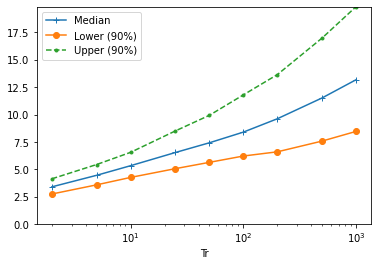

In [4]:
raw_precip = get_input_data(precip_table_dir, duration, Return_Intervals[0], display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(10)

---
## NRCS

#### Runoff Forcing Data:

In [5]:
hid = 0
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction
raw_precip_reduced['PAC'] = 1/raw_precip_reduced.index

#events and excess precip curves
prep_curves = precip_to_runoff_h1(Return_Intervals,nrcs_precip_table_dir,
                     raw_precip_reduced,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

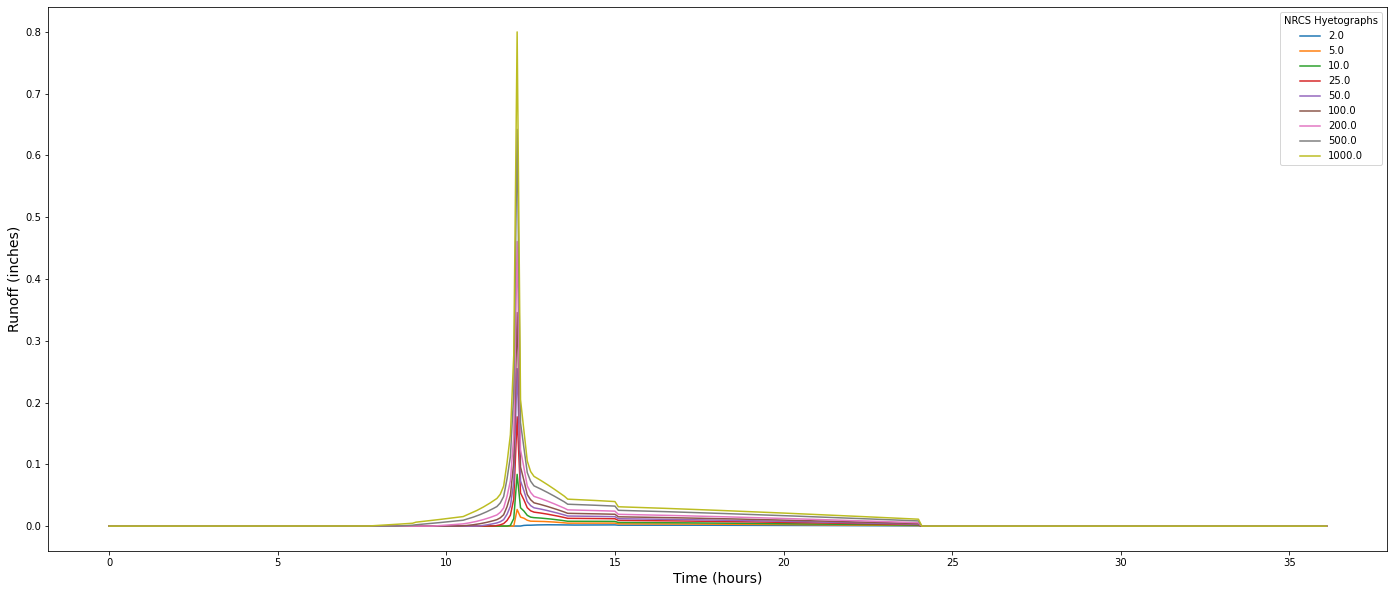

In [6]:
## test plot:
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='NRCS Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

#### Hydrology Weights:

In [7]:
#formatting
Event_Weights_Hydro = raw_precip_reduced['PAC'].apply(lambda x: '%.20f' % x).to_dict()

In [8]:
renamed_weights = {}
rename_map = {}

for k,v in Event_Weights_Hydro.items():
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)

renamed_weights

{'NRCS_2': '0.50000000000000000000',
 'NRCS_5': '0.20000000000000001110',
 'NRCS_10': '0.10000000000000000555',
 'NRCS_25': '0.04000000000000000083',
 'NRCS_50': '0.02000000000000000042',
 'NRCS_100': '0.01000000000000000021',
 'NRCS_200': '0.00500000000000000010',
 'NRCS_500': '0.00200000000000000004',
 'NRCS_1000': '0.00100000000000000002'}

In [9]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,NRCS_2,NRCS_5,NRCS_10,NRCS_25,NRCS_50,NRCS_100,NRCS_200,NRCS_500,NRCS_1000
hours,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
NRCS_2,0.50000000000000000000
NRCS_5,0.20000000000000001110
NRCS_10,0.10000000000000000555
NRCS_25,0.04000000000000000083
NRCS_50,0.02000000000000000042
NRCS_100,0.01000000000000000021
NRCS_200,0.00500000000000000010
NRCS_500,0.00200000000000000004
NRCS_1000,0.00100000000000000002


### Save Data

##### To CSV:

In [11]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration, hydrology_IDs[hid]))

In [12]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

---
## NOAA

*Rainfall totals are the same as NRCS*

#### Quartile 1 Runoff Forcing Data:

In [13]:
hid = 1
#events and excess precip curves
prep_curves = precip_to_runoff_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,CN,hid)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

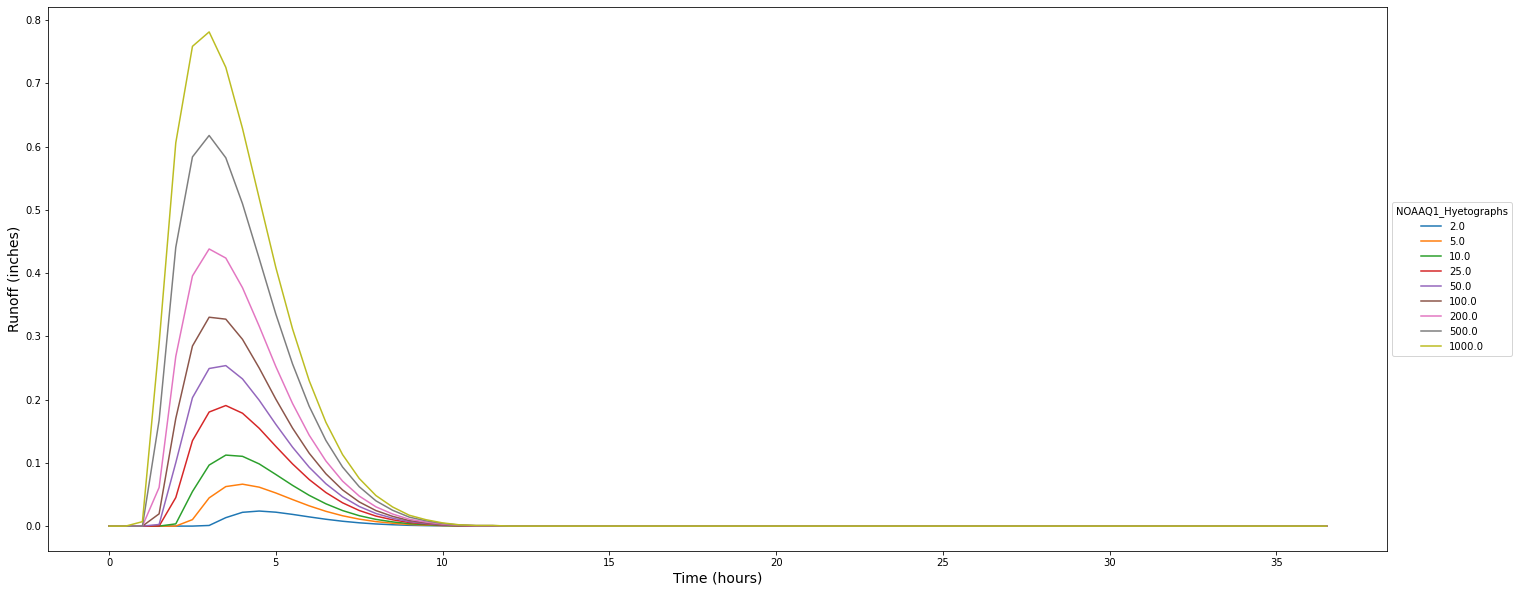

In [14]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [15]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [16]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [17]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration, hydrology_IDs[hid]))

In [18]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

#### Quartile 2 Runoff Forcing Data:

In [19]:
hid = 2
#events and excess precip curves
prep_curves = precip_to_runoff_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,CN,hid)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

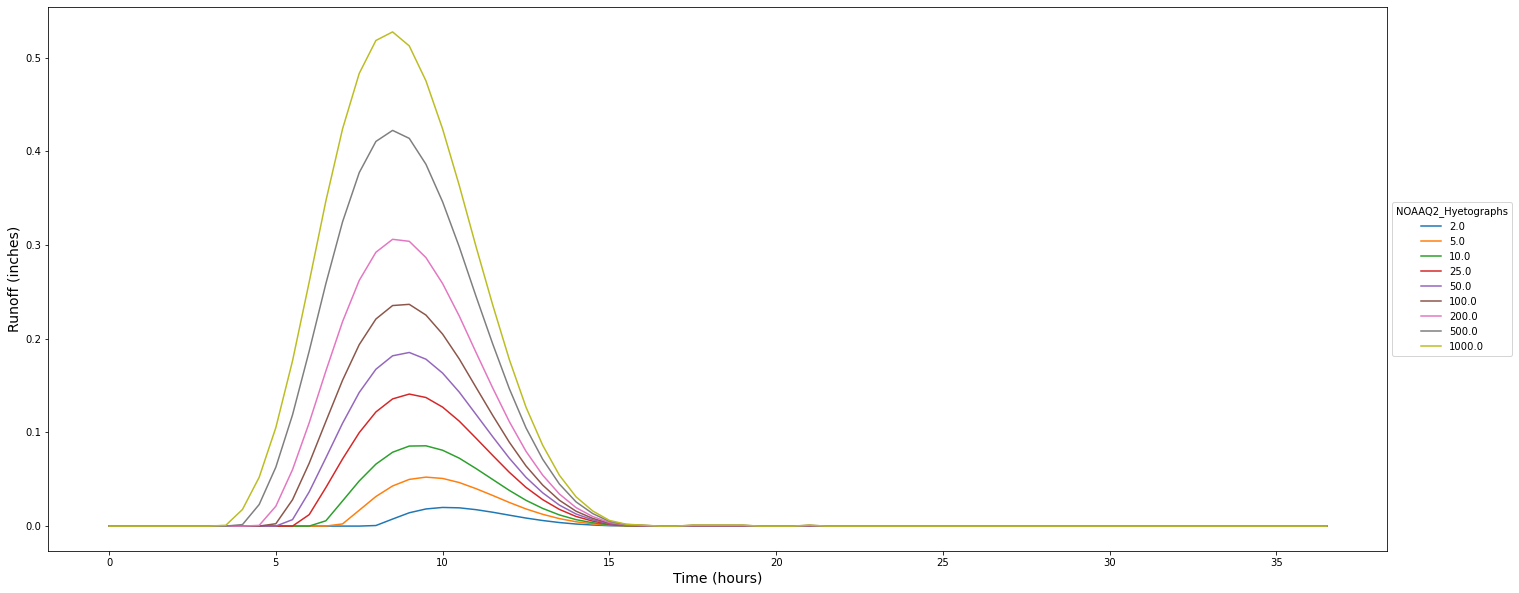

In [20]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [21]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [22]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [23]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration, hydrology_IDs[hid]))

In [24]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

#### Quartile 3 Runoff Forcing Data:

In [25]:
hid = 3
#events and excess precip curves
prep_curves = precip_to_runoff_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,CN,hid)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

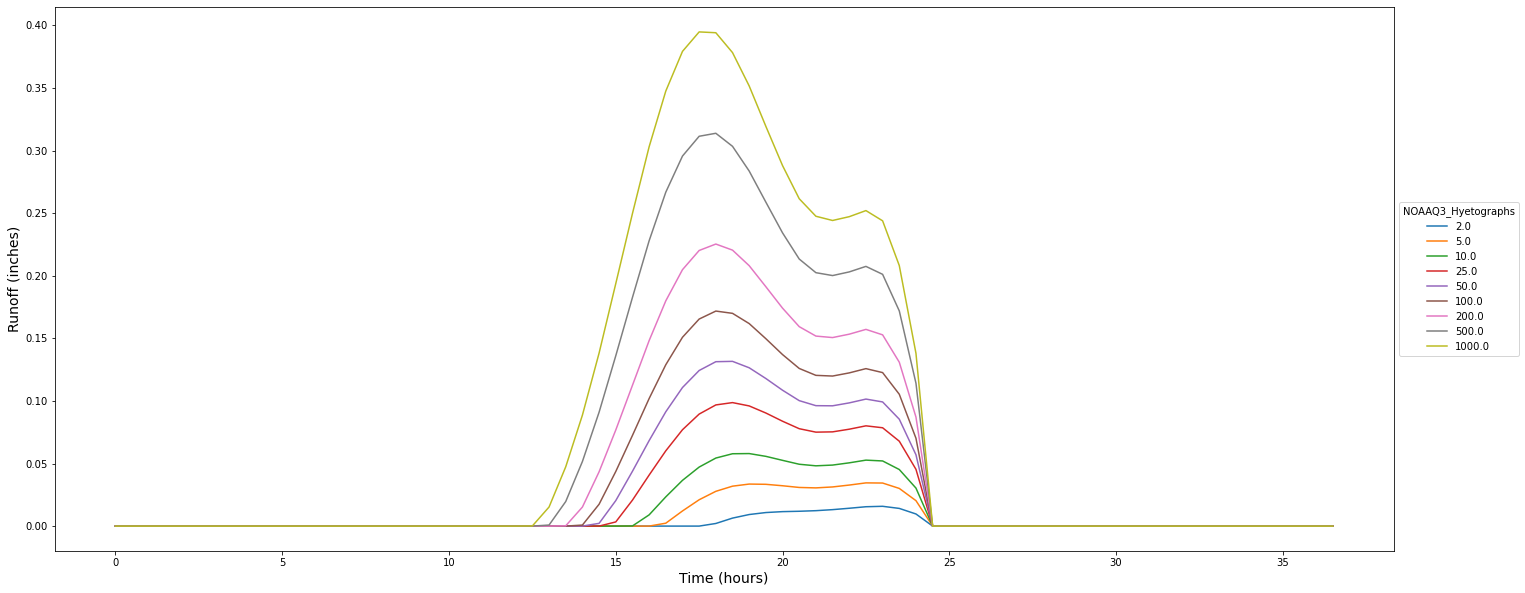

In [26]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [27]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [28]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [29]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration, hydrology_IDs[hid]))

In [30]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

#### Quartile 4 Runoff Forcing Data:

In [31]:
hid = 4
#events and excess precip curves
prep_curves = precip_to_runoff_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,CN,hid)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

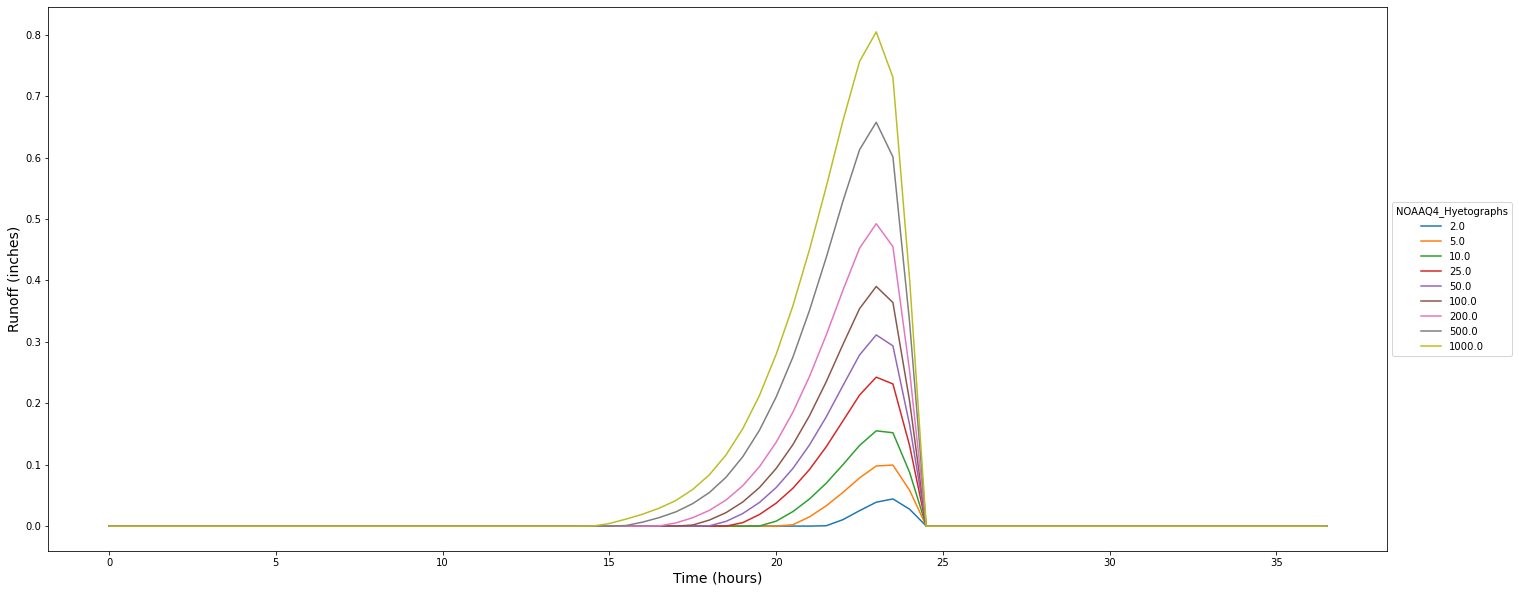

In [32]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();

In [33]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [34]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [35]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(BCN, hyet_duration, hydrology_IDs[hid]))

In [36]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.save()

## Save Outputs to JSON and DSS

### Runoff Forcing Data

In [37]:
excess_dic = combine_results_traditional('Excess_Rainfall', outputs_dir, BCN, hyet_duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(excess_dic, f)
    
forcing = '{0}_{1}_{2}'.format(Project_Area, Pluvial_Model, BCN)
jsonname = '{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN)
traditional_JSON_to_DSS.main(outputs_dir, outputs_dir, bin_dir, forcing, jsonname, scaling = True, remove_temp_files = False, display_print = True)


Converting crow_P01_crow_domain.json to DSS...
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\2D_nj_scope\pfra-hydromet\notebooks\pluvial\Outputs\crow_P01_crow_domain_NRCS.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\2D_nj_scope\pfra-hydromet\notebooks\pluvial\Outputs\crow_P01_crow_domain_NOAAQ1.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\2D_nj_scope\pfra-hydromet\notebooks\pluvial\Outputs\crow_P01_crow_domain_NOAAQ2.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\2D_nj_scope\pfra-hydromet\notebooks\pluvial\Outputs\crow_P01_crow_domain_NOAAQ3.dss
Dss File written to C:\Users\cusmith\OneDrive - Stantec Office 365\git\2D_nj_scope\pfra-hydromet\notebooks\pluvial\Outputs\crow_P01_crow_domain_NOAAQ4.dss


### Weights

In [38]:
weights_dic = combine_results_traditional('Weights',  outputs_dir, BCN, hyet_duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(weights_dic, f)

---
# End